In [1]:
"""
Check all datasets
"""
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
from ipywidgets import interact
from ipywidgets import Controller

from collections import defaultdict
import numpy as np
import os
import sys
import itertools
from tqdm import tqdm
import pandas as pd
from pprint import pprint
import regex as re
sys.path.append('/export/home/asanakoy/workspace/neural_network')
sys.path.append('/export/home/asanakoy/workspace/art_datasets')
sys.path.append('/export/home/asanakoy/workspace/dataset_merger')
import make_data.dataset
import wikiart.info.preprocess_info
from art_utils.pandas_tools import is_null_object
from art_utils.text_tools import extract_all_years
import dataset_merger.read_datasets
import dataset_merger.pymongoext as pymongoext
from dataset_merger.match_artists import fix_sim_matrix
from dataset_merger.match_artists import generate_matches_for_manual_check
from dataset_merger.match_artists import get_num_top_matches
from dataset_merger.match_artists import compute_sim_matrix
from dataset_merger.match_artists import find_connected_components
from dataset_merger.match_artists import combine_artists
from dataset_merger.match_artists import get_merged_artists_df
import dataset_merger.prepare_artists as prepare_artists
from dataset_merger.prepare_artists import get_artists_with_years

pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 160)
pd.set_option('display.max_colwidth', 50)  
pd.set_option('display.max_columns', None) 

# todo: merge wga, wikiart, artuk, googleart (dates checked)
# todo: make uniform dates (bio or active if no bio available) range for every artist in the dataset

# todo: check dates on others
# todo: chach should we split naems on `&` for other datasets (beyound artuk, wikiart, googleart, wga)
# TOD: manually check connected components (wga, artuk)

In [2]:
dfs = dataset_merger.read_datasets.read_datasets()

artuk None
artuk None 207585
googleart None
googleart None 102343
moma None
moma None 24708
rijks None
rijks None 96189
wga None
wga None 35375
wiki None
wiki None 132296
meisterwerke None
meisterwerke None 19647
Total works count: 618143
time: 13.9 s


In [3]:
# for key, df in dfs.iteritems():
#     print key
#     print df.columns
#     print '==='
    

# print '--'
# artist_names = np.unique(artist_names)
# print 'Total unique artists num:', len(artist_names)
# return artist_names

time: 2.27 ms


In [4]:
artists_with_years_dict = dict()
artists_with_years_dict['googleart'] = get_artists_with_years('googleart', dfs)
artists_with_years_dict['wiki'] = get_artists_with_years('wiki', dfs)
artists_with_years_dict['wga'] = get_artists_with_years('wga', dfs)
artists_with_years_dict['artuk'] = get_artists_with_years('artuk', dfs)
artists_with_years_dict['meisterwerke'] = get_artists_with_years('meisterwerke', dfs)
artists_with_years_dict['moma'] = get_artists_with_years('moma', dfs)

:: googleart


 32%|███▏      | 1362/4222 [00:00<00:00, 13615.11it/s]

with url_wiki: 2890


100%|██████████| 4222/4222 [00:00<00:00, 14718.56it/s]


Total artists: 4222
Drop artists with NaN years_range 138
Drop 0 unknown artists
Total artists: 4084
:: wiki


 59%|█████▉    | 1406/2384 [00:00<00:00, 14056.49it/s]

with url_wiki: 1923


100%|██████████| 2384/2384 [00:00<00:00, 13586.99it/s]


Total artists: 2384
Drop artists with NaN years_range 6
Drop 0 unknown artists
Total artists: 2378
:: wga


 30%|██▉       | 1372/4577 [00:00<00:00, 13689.46it/s]

with url_wiki: 26


100%|██████████| 4577/4577 [00:00<00:00, 10703.58it/s]


Total artists: 4577
Drop artists with NaN years_range 0
Drop 0 unknown artists
Total artists: 4577
:: artuk


  0%|          | 0/37074 [00:00<?, ?it/s]

with url_wiki: 0


100%|██████████| 37074/37074 [00:02<00:00, 14671.87it/s]


Total artists: 37074
Drop artists with NaN years_range 3609
Drop 0 unknown artists
Total artists: 33465
:: meisterwerke


100%|██████████| 2272/2272 [00:00<00:00, 15600.96it/s]

with url_wiki: 3
Total artists: 2272
Drop artists with NaN years_range 33
Drop 17 unknown artists
Total artists: 2222
:: moma



 12%|█▏        | 1781/15247 [00:00<00:00, 17806.45it/s]

with url_wiki: 0


100%|██████████| 15247/15247 [00:00<00:00, 16581.35it/s]


Total artists: 15247
Drop artists with NaN years_range 3576
Drop 0 unknown artists
Total artists: 11671
time: 16.4 s


In [5]:
# artcyclopedia_artists = pymongoext.get_db_entries('129.206.117.36', 27017, 'artcyclopedia', 'found')
# for x in artcyclopedia_artists:
#     x['artcylopedia_name'] = x['name']
#     del x['name']
#     del x['_id']
#     if 'content' in x:
#         del x['content']
# print len(artcyclopedia_artists)
# print artcyclopedia_artists[:2]

# artcyclopedia_df = pd.DataFrame.from_dict(artcyclopedia_artists)
# artcyclopedia_df.index = artcyclopedia_df['artist_name']
# artcyclopedia_df.rename(columns={'url': 'url_artcyclopedia'}, inplace=True)

# # artists_df['url_artcyclopedia'] = artcyclopedia_df.loc[artist_names, 'url_artcyclopedia'].values
# # print pd.notnull(artists_df['url_artcyclopedia']).sum()
# print len(artcyclopedia_df)
# print len(artcyclopedia_df['url_artcyclopedia'].unique())


# artcyclopedia_df

time: 3.96 ms


In [6]:
def get_sim_matrix(dataset_names, shape=None, force=False, n_jobs=1):
    assert len(dataset_names) == 2
    str_name = '-'.join(dataset_names)
    matrix_filepath = 'sim_matrix_{}.npy'.format(str_name)
    if os.path.exists(matrix_filepath) and not force:
        sim = np.load(matrix_filepath)
        if shape is not None:
            assert shape == sim.shape, '{} != {}'.format(shape, sim.shape)
    else:
        sim = compute_sim_matrix(keys, artists_with_years_dict, n_jobs=n_jobs)
        np.save(matrix_filepath, sim)
        print 'Sim matrix saved to {}'.format(matrix_filepath)
    return sim

def get_sim_matrix_and_plot(dataset_names, force=False, n_jobs=1):
    str_name = '-'.join(dataset_names)
    print str_name
    shape = tuple([len(artists_with_years_dict[dataset_names[i]]) for i in xrange(2)])
    sim_matrix[str_name] = get_sim_matrix(dataset_names, shape=shape, force=force, n_jobs=n_jobs)
    print sim_matrix[str_name].shape
    best_sim = sim_matrix[str_name].max(axis=1)
    plt.hist(best_sim)
    plt.show()

sim_matrix = dict()

time: 25 ms


In [7]:
def check_pairs(dataset_names, transpose=False, 
                min_sim=85, max_sim=100, 
                discard_exaclty_matched_dates=False,
                min_k=1, min_total_works_count=0):
    assert len(dataset_names) == 2
    sim = sim_matrix['-'.join(dataset_names)]
    dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

    manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
    if os.path.exists(manually_checked_matches_path):
        manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0, encoding='utf-8')
        print 'manually checked pairs:', len(manually_checked_matches_df)
        sim = fix_sim_matrix(dataset_names, 
                             dfs_to_merge, 
                             sim, 
                             manually_checked_matches_df)
    
    if transpose:
        # Transpose matches
        dataset_names = dataset_names[::-1]
        dfs_to_merge = dfs_to_merge[::-1]
        sim = sim.transpose()

    results_df = generate_matches_for_manual_check(dataset_names, dfs_to_merge, 
                                                   sim, min_sim=min_sim, max_sim=max_sim,
                                                   discard_exaclty_matched_dates=discard_exaclty_matched_dates,
                                                   min_k=min_k, 
                                                   min_total_works_count=min_total_works_count)
    output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names))
    results_df.to_csv(output_path, encoding='utf-8')
    return results_df

time: 23.6 ms


In [8]:
def correct_ids_in_manually_checked_matches(dataset_names):
    """
        Check each pair in manually_checked_matches and change $artist_id to one from 'artist_ids' list (if possible)
        if $artist_id is not currently in index of the artist_df
    """
    
    manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
    if not os.path.exists(manually_checked_matches_path):
        raise IOError('File {} not found'.format(manually_checked_matches_path))
    manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0, encoding='utf-8')
    print 'manually checked pairs:', len(manually_checked_matches_df)

    dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]
    
    def convert_to_valid_idx(artists_df, artist_id):
        if artist_id not in artists_df.index:
            found_idxs = np.nonzero(artists_df['artist_ids'].apply(lambda x: artist_id in x))[0]
            if len(found_idxs):
                assert len(found_idxs) == 1, '{}: {}'.format(artist_id, found_idxs)
                artist_id = artists_df.index[found_idxs[0]]
        return artist_id
        
    
    def is_valid_pairs(row):
        for i in xrange(2):
            artist_id = row['artist_id_' + dataset_names[i]]
            if artist_id not in dfs_to_merge[i].index:
                return False
        return True
    
    is_valid = manually_checked_matches_df.apply(is_valid_pairs, axis=1)
    print 'not valid before fixes:', (~is_valid).sum()
    print manually_checked_matches_df[~is_valid]
    
    for i in xrange(2):
        manually_checked_matches_df['artist_id_' + dataset_names[i]] = \
            manually_checked_matches_df['artist_id_' + dataset_names[i]] \
            .apply(lambda x: convert_to_valid_idx(dfs_to_merge[i], x))
    
    is_valid = manually_checked_matches_df.apply(is_valid_pairs, axis=1)
    print 'not valid', (~is_valid).sum()
    print manually_checked_matches_df[~is_valid]
    return manually_checked_matches_df

# dataset_names = ['wiki+googleart', 'wga']
# dataset_names = ['wiki+googleart+wga', 'meisterwerke']
# manually_checked_matches_df = correct_ids_in_manually_checked_matches(dataset_names)
# manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
# manually_checked_matches_df.to_csv(manually_checked_matches_path, encoding='utf-8')

time: 50.2 ms


In [9]:
# def fix_wga_ids(matches_df):
    
#     def years_range_to_suffix(years_range):
#         if not isinstance(years_range, float):
#             assert isinstance(years_range, list)
#             return ', ({}-{})'.format(*np.asarray(years_range, dtype=int))
#         else:
#             return ''
    
#     matches_df = matches_df.copy()
#     fixed_bio_df = pd.read_csv('/export/home/asanakoy/workspace/wga/info/duplicate_artists_fixed_bio.csv', encoding='utf-8', header=0)
#     for row in fixed_bio_df.itertuples():
#         new_years_bio = map(int, re.split(r',|-', row.fixed_bio.strip()))
#         mask = matches_df['artist_id_wga'] == row.artist_id
#         matches_df.loc[mask, 'dates_wga'] = matches_df.loc[mask, 'dates_wga'].apply(lambda _: new_years_bio)
#         matches_df.loc[mask, 'artist_id_wga'] = matches_df.loc[mask, 'artist_id_wga'].apply(lambda x: x.rsplit(',', 1)[0] + 
#                                                                            years_range_to_suffix(new_years_bio))
#     return matches_df

# dataset_names = ['wiki+googleart', 'wga']
# manually_checked_matches_df = fix_wga_ids(manually_checked_matches_df)
# manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
# manually_checked_matches_df.to_csv(manually_checked_matches_path, encoding='utf-8')

time: 11.3 ms


In [10]:
%autoreload

time: 126 ms


wiki-googleart


  0%|          | 0/2378 [00:00<?, ?it/s]

Num taks: 2378


100%|██████████| 2378/2378 [03:34<00:00, 10.69it/s]
[Parallel(n_jobs=16)]: Done 2378 out of 2378 | elapsed:  3.7min finished


Sim matrix saved to sim_matrix_wiki-googleart.npy
(2378, 4084)


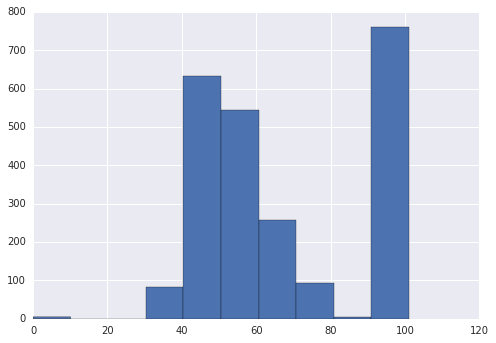

time: 3min 43s


In [11]:
keys = ['wiki', 'googleart']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

# keys = ['wga', 'artuk']
# get_sim_matrix_and_plot(keys)

In [12]:
check_pairs(['wiki', 'googleart'], 
            transpose=False,
            min_sim=76, max_sim=101, 
            discard_exaclty_matched_dates=True,
            min_k=1)

manually checked pairs: 175
Not found googleart: :googleart_m06vf96:
Not found googleart: :googleart_m0t502qr:
Not found googleart: :googleart_m0420fk:
Not found googleart: :googleart_t219hrtqpy4:
Not found googleart: :googleart_t219hrtqpy4:
count: 0
0


""


time: 845 ms


In [13]:
def check_sim_values(dataset_names, artist_ids):
    cur_dfs = [artists_with_years_dict[key] for key in dataset_names]
    indices = [0, 0]
    for i in xrange(2):
        idx = np.nonzero(cur_dfs[i]['artist_id'] == artist_ids[i])[0][0]
        print cur_dfs[i].iloc[idx]
        print '---'
        indices[i] = idx
    print indices
    sim = get_sim_matrix(dataset_names, force=False)
    print 'sim=', sim[indices[0], indices[1]]

check_sim_values(['wiki', 'googleart'], ['wiki_johan-hendrik-weissenbruch', 'googleart_m026t8y5'])

art_institution                                                         NaN
art_movement                                                      [realism]
artist_id                                   wiki_johan-hendrik-weissenbruch
artist_name                                      johan hendrik weissenbruch
birth_date                                                     19 june 1824
death_date                                                    24 march 1903
description                                                             NaN
field                                                            [painting]
friends_and_co-workers                                                  NaN
genre                                                           [landscape]
influenced_by                                                           NaN
influenced_on                                                           NaN
nationality                                                         [dutch]
painting_sch

In [ ]:
dataset_names = ['wiki', 'googleart']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim, allow_big_components=False)
artists_with_years_dict['wiki+googleart'] = merged_df

Not found googleart: :googleart_m06vf96:
Not found googleart: :googleart_m0t502qr:
Not found googleart: :googleart_m0420fk:


  0%|          | 0/2378 [00:00<?, ?it/s]

Not found googleart: :googleart_t219hrtqpy4:
Not found googleart: :googleart_t219hrtqpy4:
connected_components at the beginning: 6462


  1%|▏         | 83/5711 [00:00<00:06, 828.29it/s]

connected_components: 5711
big_components number: 0


100%|██████████| 5711/5711 [00:05<00:00, 1012.84it/s]


time: 11.1 s


In [ ]:
%autoreload
keys = ['wiki+googleart', 'wga']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

wiki+googleart-wga


  0%|          | 0/5711 [00:00<?, ?it/s]

Num taks: 5711


 84%|████████▎ | 4781/5711 [07:25<01:27, 10.65it/s]

In [ ]:
%autoreload
dataset_names = ['wiki+googleart', 'wga']
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=78, max_sim=120, 
                discard_exaclty_matched_dates=False,
                min_k=2)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=78, max_sim=121, 
                discard_exaclty_matched_dates=False,
                min_k=2)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_wga', 'artist_id_wiki+googleart'])
    appended = appended[results_df.columns]
else:
    appended = results_df_transposed

# appended = results_df
output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
appended

In [ ]:
# artists_with_years_dict['googleart']['url_wiki'] = artists_with_years_dict['googleart']['url_wiki'].apply(lambda x: 'https://en.wikipedia.org/wiki/ernest_meissonier' if x == 'http://en.wikipedia.org/wiki/jean-louis-ernest_meissonier' else x)


# ids = list()
# for comp in big_comp_wiki_googleart:
#     comp = sorted(list(comp))
#     ids.extend(comp[:2])
# artists_with_years_dict['wiki+googleart'][['artist_name', 'years_range', 'url_wiki']].iloc[ids]

In [ ]:
dataset_names = ['wiki+googleart', 'wga']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim, allow_big_components=False)
artists_with_years_dict['+'.join(dataset_names)] = merged_df
merged_df.to_hdf('artists_{}.hdf5'.format('+'.join(dataset_names)), 'df', mode='w')
# merged_df

In [ ]:
artists_with_years_dict.keys()

In [ ]:
dataset_names = ['wiki', 'googleart', 'wga', 'wiki+googleart+wga']
for key in dataset_names:
    print '{}: {} unique artists'.format(key, len(artists_with_years_dict[key]))

In [ ]:
##### MEISTERWERKE #######

%autoreload
keys = ['wiki+googleart+wga', 'meisterwerke']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

In [ ]:
def get_pairs_from_the_same_dataset(dataset_names, df, min_sim=102):
    df = df[df['score'] >= min_sim].copy()
    fir_ids_col = 'artist_id_' + dataset_names[0]
    sec_ids_col = 'artist_id_' + dataset_names[1]
    df.index = df[sec_ids_col]
    df_gr = pd.DataFrame(data={sec_ids_col: 
                            df.groupby(fir_ids_col)[sec_ids_col].apply(list)})
    df_gr['dates'] = df_gr[sec_ids_col].apply(lambda x: [df.at[el, 'dates_' + dataset_names[1]] for el in x])
    df_gr[sec_ids_col] = df_gr[sec_ids_col].apply(lambda x: ';'.join(x))
    return df_gr

In [ ]:
##### MEISTERWERKE #######
%autoreload
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
results_df = []
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=85, max_sim=101, 
                discard_exaclty_matched_dates=False,
                min_k=1,
                min_total_works_count=1)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = []
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=85, max_sim=101, 
                discard_exaclty_matched_dates=False,
                min_k=1,
                min_total_works_count=1)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df) and len(results_df_transposed):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_' + key for key in dataset_names])
    appended = appended[results_df.columns]
#     assert len(appended['artist_id_meisterwerke'].unique()) == len(appended), len(appended['artist_id_meisterwerke'].unique())
    appended.sort_values(by='artist_id_wiki+googleart+wga', inplace=True)
elif len(results_df):
    appended = results_df
elif len(results_df_transposed):
    appended = results_df_transposed
else:
    appended = pd.DataFrame()
    
# appended.sort_values(by='artist_id_wiki+googleart+wga', inplace=True)
# appended.sort_values(by='artist_id_meisterwerke', inplace=True)


from os.path import expanduser
output_path = expanduser('~/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names)))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
print dataset_names
appended
# duplicates_df = get_pairs_from_the_same_dataset(dataset_names[::-1], appended, min_sim=100)
# output_path = expanduser('~/workspace/dataset_merger/aggregated/{}_duplicates.csv'.format(dataset_names[1]))
# duplicates_df.to_csv(output_path, encoding='utf-8')
# duplicates_df

In [ ]:
##### MEISTERWERKE #######
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

# artists_with_years_dict['+'.join(dataset_names)] = get_merged_artists_df(dataset_names, dfs_to_merge, sim)


assert len(dataset_names) == len(dfs_to_merge)
assert sim.shape == (len(dfs_to_merge[0]), len(dfs_to_merge[1])), sim.shape


manually_checked_matches_path = 'manually_corrected_matches/{}_manually_corrected_matches.csv'.format(
    '-'.join(dataset_names))
if os.path.exists(manually_checked_matches_path):
    manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0,
                                              encoding='utf-8')
    sim = fix_sim_matrix(dataset_names,
                                dfs_to_merge,
                                sim,
                                manually_checked_matches_df)

connected_components = find_connected_components(sim, min_sim=100)
big_comp = [x for x in connected_components if len(x) > 2]
small_comp = [x for x in connected_components if len(x) <= 2]
# connected_components = small_comp + [{el} for x in big_comp for el in x]
# big_comp = [x for x in connected_components if len(x) > 2]

print 'num big_comp', len(big_comp)
# assert len(big_comp) == 0, len(big_comp)
big_comp

In [ ]:
# TODO: filter out big components. Recheck them
# TODO: merge images wga wiki. googleart
# these are mostly followers of the artists in the meisterwerke and workshops.
# But they have to be manually checked
big_comp
items_list = []
for comp in big_comp:
    for item_id in comp:
        df_idx = item_id / int(1e6)
#         if df_idx == 0:
#             continue
        artist_idx = item_id % int(1e6)
        items_list.append(dfs_to_merge[df_idx].iloc[artist_idx][['artist_id', 'artist_names', 'years_range']])
pd.DataFrame(items_list)

In [ ]:
%autoreload
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim, 
                                  split_big_components=False, 
                                  allow_big_components=False)
artists_with_years_dict['+'.join(dataset_names)] = merged_df
print 'Num unique artists:', len(merged_df)
merged_df

In [ ]:
artists_with_years_dict['wiki'].loc['wiki_abdul-qader-al-raes']

In [ ]:
dataset_names = ['wiki', 'googleart', 'wga', 'meisterwerke', 'moma', 'wiki+googleart+wga+meisterwerke']
for key in dataset_names:
    print '{}: {} unique artists'.format(key, len(artists_with_years_dict[key]))

In [ ]:
##### MOMA #######

%autoreload
keys = ['wiki+googleart+wga+meisterwerke', 'moma']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

In [ ]:
##### MOMA #######
%autoreload
dataset_names = ['wiki+googleart+wga+meisterwerke', 'moma']
results_df = []
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=84, max_sim=101, 
                discard_exaclty_matched_dates=True,
                min_k=1,
                min_total_works_count=0)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = []
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=84, max_sim=101, 
                discard_exaclty_matched_dates=True,
                min_k=1,
                min_total_works_count=0)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df) and len(results_df_transposed):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_' + key for key in dataset_names])
    appended = appended[results_df.columns]
#     assert len(appended['artist_id_meisterwerke'].unique()) == len(appended), len(appended['artist_id_meisterwerke'].unique())
    appended.sort_values(by='artist_id_' + dataset_names[0], inplace=True)
elif len(results_df):
    appended = results_df
elif len(results_df_transposed):
    appended = results_df_transposed
else:
    appended = pd.DataFrame()
    
# appended.sort_values(by='artist_id_wiki+googleart+wga', inplace=True)
# appended.sort_values(by='artist_id_meisterwerke', inplace=True)


from os.path import expanduser
output_path = expanduser('~/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names)))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
print dataset_names
appended
# duplicates_df = get_pairs_from_the_same_dataset(dataset_names[::-1], appended, min_sim=100)
# output_path = expanduser('~/workspace/dataset_merger/aggregated/{}_duplicates.csv'.format(dataset_names[1]))
# duplicates_df.to_csv(output_path, encoding='utf-8')
# duplicates_df

In [ ]:
%autoreload
dataset_names = ['wiki+googleart+wga+meisterwerke', 'moma']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim, 
                                  split_big_components=False, 
                                  allow_big_components=False)
merged_df = merged_df[merged_df['works_count'] > 0]
artists_with_years_dict['+'.join(dataset_names)] = merged_df
print 'Num unique artists:', len(merged_df)
# merged_df.to_hdf('info/artists_{}_v0.93.hdf5'.format('+'.join(dataset_names)), 'df', mode='w')
merged_df.head()

In [ ]:
for key in artists_with_years_dict.keys():
    print '{}: {} unique artists'.format(key, len(artists_with_years_dict[key]))

In [ ]:
##### ARTUK #######
%autoreload
keys = ['wiki+googleart+wga+meisterwerke+moma', 'artuk']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

In [ ]:
##### ARTUK #######
%autoreload
dataset_names = ['wiki+googleart+wga+meisterwerke+moma', 'artuk']
results_df = []
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=84, max_sim=101, 
                discard_exaclty_matched_dates=True,
                min_k=1,
                min_total_works_count=0)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = []
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=84, max_sim=101, 
                discard_exaclty_matched_dates=True,
                min_k=1,
                min_total_works_count=0)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df) and len(results_df_transposed):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_' + key for key in dataset_names])
    appended = appended[results_df.columns]
#     assert len(appended['artist_id_meisterwerke'].unique()) == len(appended), len(appended['artist_id_meisterwerke'].unique())
    appended.sort_values(by='artist_id_' + dataset_names[0], inplace=True)
elif len(results_df):
    appended = results_df
elif len(results_df_transposed):
    appended = results_df_transposed
else:
    appended = pd.DataFrame()
    
# appended.sort_values(by='artist_id_wiki+googleart+wga', inplace=True)
# appended.sort_values(by='artist_id_meisterwerke', inplace=True)


from os.path import expanduser
output_path = expanduser('~/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names)))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
print dataset_names
appended
# duplicates_df = get_pairs_from_the_same_dataset(dataset_names[::-1], appended, min_sim=100)
# output_path = expanduser('~/workspace/dataset_merger/aggregated/{}_duplicates.csv'.format(dataset_names[1]))
# duplicates_df.to_csv(output_path, encoding='utf-8')
# duplicates_df

In [ ]:
%autoreload
dataset_names = ['wiki+googleart+wga+meisterwerke+moma', 'artuk']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim, 
                                  split_big_components=False, 
                                  allow_big_components=False)
merged_df = merged_df[merged_df['works_count'] > 0]
artists_with_years_dict['+'.join(dataset_names)] = merged_df
print 'Num unique artists:', len(merged_df)
# merged_df.to_hdf('info/artists_{}_v0.93.hdf5'.format('+'.join(dataset_names)), 'df', mode='w')
merged_df.head()